### EDA

In [12]:
from pprint import pprint
import torch
from huggingface_hub import HfApi
import numpy as np
import matplotlib.pyplot as plt

import lerobot
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata

# Load PushT dataset metadata (lightweight, no data download yet)
repo_id = "lerobot/pusht"
ds_meta = LeRobotDatasetMetadata(repo_id)

print(f"\n=== PushT Dataset Metadata ===")
print(f"Total episodes: {ds_meta.total_episodes}")
print(f"Total frames: {ds_meta.total_frames}")
print(f"Average frames per episode: {ds_meta.total_frames / ds_meta.total_episodes:.3f}")
print(f"FPS: {ds_meta.fps}")
print(f"Robot type: {ds_meta.robot_type}")
print(f"Camera keys: {ds_meta.camera_keys}")

print(f"\nTasks:")
pprint(ds_meta.tasks)

print(f"\nFeatures:")
pprint(ds_meta.features)

# Short summary
print(f"\nDataset summary:")
print(ds_meta)


=== PushT Dataset Metadata ===
Total episodes: 206
Total frames: 25650
Average frames per episode: 124.515
FPS: 10
Robot type: unknown
Camera keys: ['observation.image']

Tasks:
{0: 'Push the T-shaped block onto the T-shaped target.'}

Features:
{'action': {'dtype': 'float32',
            'names': {'motors': ['motor_0', 'motor_1']},
            'shape': (2,)},
 'episode_index': {'dtype': 'int64', 'names': None, 'shape': (1,)},
 'frame_index': {'dtype': 'int64', 'names': None, 'shape': (1,)},
 'index': {'dtype': 'int64', 'names': None, 'shape': (1,)},
 'next.done': {'dtype': 'bool', 'names': None, 'shape': (1,)},
 'next.reward': {'dtype': 'float32', 'names': None, 'shape': (1,)},
 'next.success': {'dtype': 'bool', 'names': None, 'shape': (1,)},
 'observation.image': {'dtype': 'video',
                       'names': ['height', 'width', 'channel'],
                       'shape': (96, 96, 3),
                       'video_info': {'has_audio': False,
                                     

In [13]:
from huggingface_hub import snapshot_download
import os

# Download PushT dataset to a specific local directory
local_data_dir = "./local_data_dir"
os.makedirs(local_data_dir, exist_ok=True)

# Downloading PushT dataset if not done yet
# dataset_path = snapshot_download(
#     repo_id="lerobot/pusht",
#     repo_type="dataset", 
#     local_dir=f"{local_data_dir}/lerobot/pusht",
# )

# load pushT dataset from local directory
from lerobot.datasets.lerobot_dataset import LeRobotDataset

dataset = LeRobotDataset(
    repo_id="lerobot/pusht",
    root=local_data_dir,
)

print(f"✓ Loaded dataset from local directory")
print(f"Episodes: {dataset.num_episodes}, Frames: {dataset.num_frames}")

Resolving data files:   0%|          | 0/206 [00:00<?, ?it/s]

✓ Loaded dataset from local directory
Episodes: 206, Frames: 25650


Resolving data files:   0%|          | 0/206 [00:00<?, ?it/s]

Visualizing Episode 0: frames 0 to 160
Loaded 12 frames
Image shape: torch.Size([5, 3, 96, 96]) (C, H, W)
Action shape: (12, 7, 2)
State shape: (12, 5, 2)


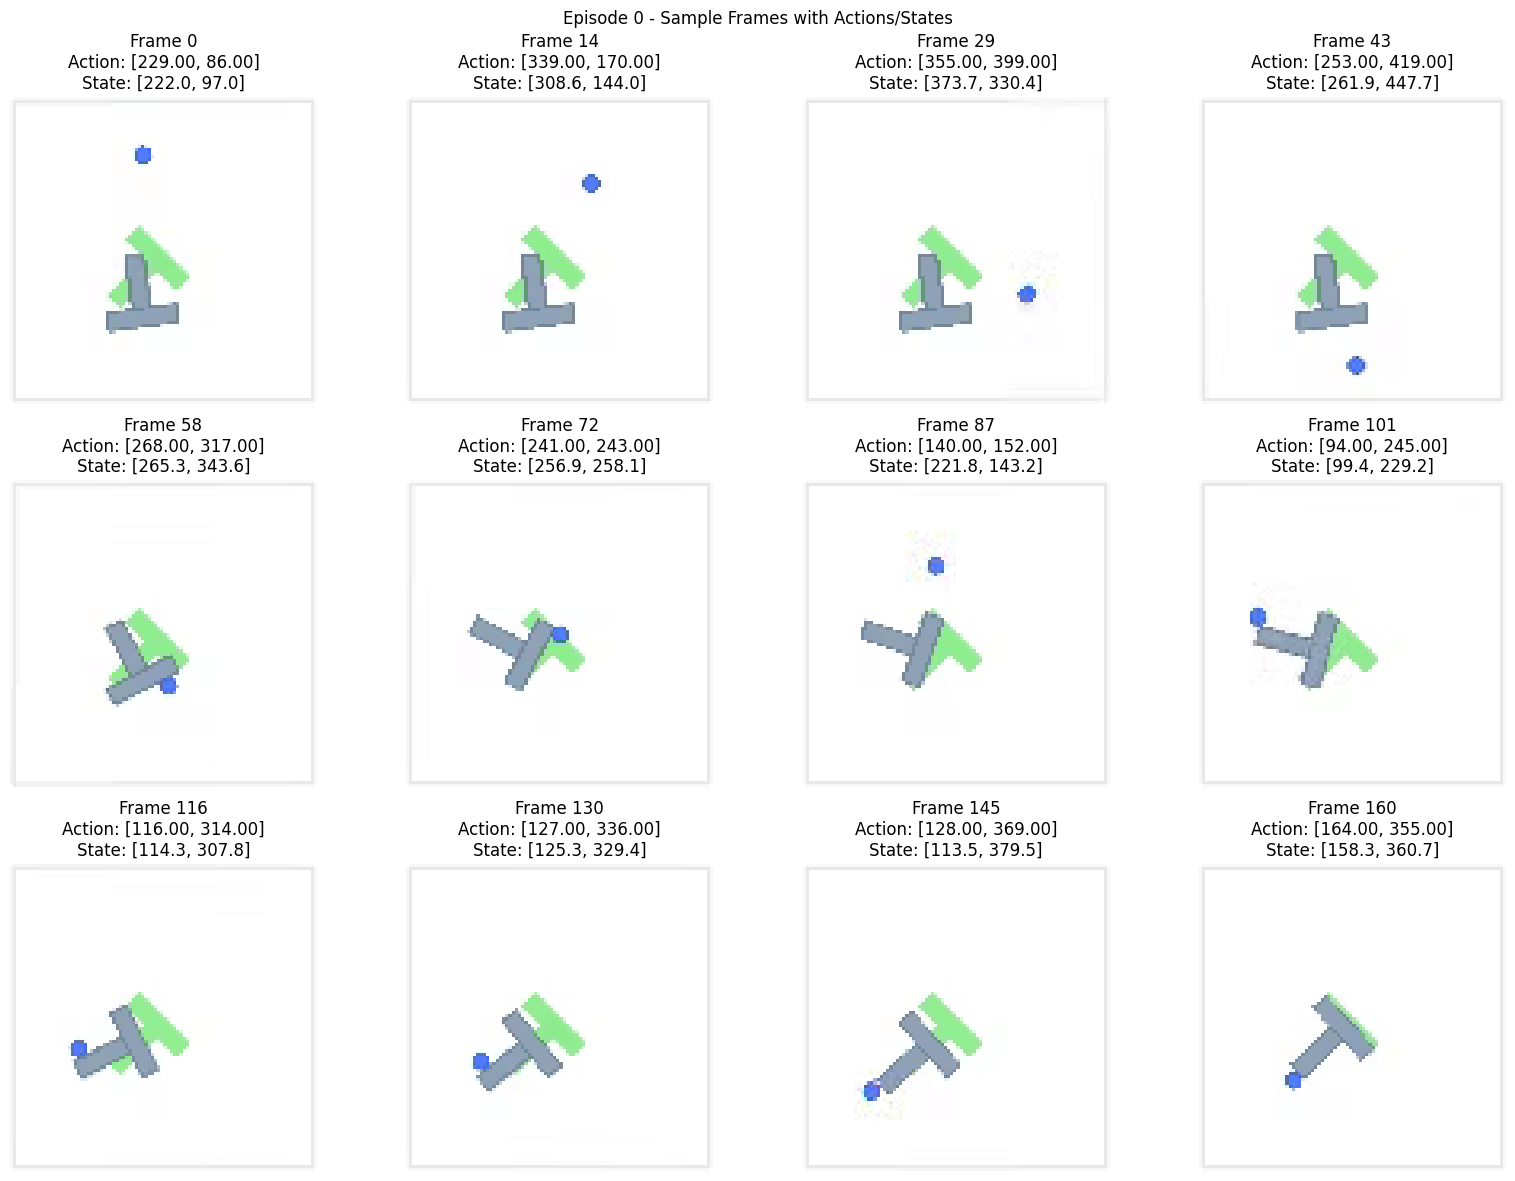

In [14]:
dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)
# Get data from first episode
episode_index = 0
from_idx = dataset.episode_data_index["from"][episode_index].item()
to_idx = dataset.episode_data_index["to"][episode_index].item()

print(f"Visualizing Episode {episode_index}: frames {from_idx} to {to_idx-1}")

# Load sample frames (evenly spaced)
num_frames_to_show = 12
frame_indices = np.linspace(from_idx, to_idx-1, num_frames_to_show, dtype=int)

frames = []
actions = []
states = []

for idx in frame_indices:
    frame_data = dataset[int(idx)]
    frames.append(frame_data['observation.image'])
    actions.append(frame_data['action'].numpy())
    states.append(frame_data['observation.state'].numpy())

actions = np.array(actions)
states = np.array(states)

print(f"Loaded {len(frames)} frames")
print(f"Image shape: {frames[0].shape} (C, H, W)")
print(f"Action shape: {actions.shape}")
print(f"State shape: {states.shape}")

# Visualize frames
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, (frame, action, state) in enumerate(zip(frames, actions, states)):
    if i >= len(axes):
        break
    
    # use last time step (current frame)
    current_frame = frame[-1]  # Shape: [3, 96, 96]
    
    # Convert from CHW to HWC for matplotlib
    img = current_frame.permute(1, 2, 0)
    img_np = img.numpy()
    
    # Handle different value ranges
    if img_np.max() <= 1.0:
        img_np = (img_np * 255).astype(np.uint8)
    
    # Also fix action/state indexing - use current time step
    current_action = action[-1]  # Shape: [2]
    current_state = state[-1]    # Shape: [2]
    
    axes[i].imshow(img_np)
    axes[i].set_title(f'Frame {frame_indices[i]}\nAction: [{current_action[0]:.2f}, {current_action[1]:.2f}]\nState: [{current_state[0]:.1f}, {current_state[1]:.1f}]')
    axes[i].axis('off')

plt.suptitle(f'Episode {episode_index} - Sample Frames with Actions/States')
plt.tight_layout()
plt.show()

### Train BeT

In [15]:
from test_bet_implementation import test_bet_implementation
test_bet_implementation() # just as sanity check, overfit on single batch

Using device: cuda
number of parameters: 26.00M
self._offset_loss_multiplier: 10000


Resolving data files:   0%|          | 0/206 [00:00<?, ?it/s]

=== Overfitting Single Batch ===
Batch size: 2
Action shape: torch.Size([2, 7, 2])
K-means fitting steps: 300
Total training steps: 1300
K-means fitting step 0: Loss = -0.000000
  Classification: 0.000000
  Offset (unscaled): 0.000000
K-means fitting step 200: Loss = 0.000000
  Classification: 0.000000
  Offset (unscaled): 0.000000


K-means clustering: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 805.45it/s]


done step 1/100, re-initialized 4 dead clusters
done step 2/100, re-initialized 2 dead clusters
K-means fitting step 299: Loss = 508.516144
  Classification: 2.112524
  Offset (unscaled): 0.050640
Training step 100: Loss = 109.368614
  Classification: 2.011964
  Offset (unscaled): 0.010736
Training step 300: Loss = 63.390984
  Classification: 2.015740
  Offset (unscaled): 0.006138
Training step 500: Loss = 28.048155
  Classification: 2.065623
  Offset (unscaled): 0.002598
Training step 700: Loss = 23.935797
  Classification: 2.041246
  Offset (unscaled): 0.002189
Training step 900: Loss = 16.394825
  Classification: 2.047198
  Offset (unscaled): 0.001435
  Final prediction MSE: 0.177381

Loss progression (training phase only):
  K-means fitting completed at step 300
  Training start loss: 13948.902344
  After 10 training steps: 11981.888672
  After 100 training steps: 106.193459
  Final training loss: 16.694124
  Training loss reduction: 99.9%


In [16]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import torch
from lerobot.configs.types import FeatureType
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.datasets.utils import dataset_to_policy_features
from lerobot.policies.bet.configuration_bet import BeTConfig
from lerobot.policies.bet.modeling_bet import BeTPolicy

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Create a directory to store the training checkpoint.
output_directory = Path("outputs/train/test_bet")
output_directory.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda")

training_steps = 5000
losses = []
classification_losses = []
offset_losses = []
log_freq = 100

#  specify 2 things before creating the policy:
#   - input/output shapes: to properly size the policy
#   - dataset stats: for normalization and denormalization of input/outputs
dataset_metadata = LeRobotDatasetMetadata("lerobot/pusht")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

cfg = BeTConfig(input_features=input_features, output_features=output_features)

# We can now instantiate our policy with this config and the dataset stats.
policy = BeTPolicy(cfg, dataset_stats=dataset_metadata.stats)

policy.train()
policy.to(device)

delta_timestamps = {
    "observation.image": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "observation.state": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
}

dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)

# Then we create our optimizer and dataloader for offline training.
optimizer = torch.optim.Adam(policy.parameters(), lr=3e-4)
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=64,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)

# Run training loop.
step = 0
done = False
while not done:
    for batch in dataloader:
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        loss, loss_dict = policy.forward(batch)
        cl_loss, offset_loss = loss_dict.pop('classification_loss'), loss_dict.pop('offset_loss')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % log_freq == 0:
            print(f"step: {step} loss: {loss.item():.3f}")
        
        losses.append(loss.item())
        classification_losses.append(cl_loss)
        offset_losses.append(offset_loss)
        step += 1
        if step >= training_steps:
            done = True
            break

# policy.save_pretrained(output_directory)

number of parameters: 26.00M
self._offset_loss_multiplier: 10000


Resolving data files:   0%|          | 0/206 [00:00<?, ?it/s]

step: 0 loss: 0.000
step: 100 loss: 0.000
step: 200 loss: 0.000
step: 300 loss: 0.000
step: 400 loss: 0.000
step: 500 loss: 0.000
step: 600 loss: 0.000
step: 700 loss: 0.000
step: 800 loss: 0.000
step: 900 loss: 0.000


K-means clustering: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  7.72it/s]


step: 1000 loss: 3138.705
step: 1100 loss: 70.836
step: 1200 loss: 84.722
step: 1300 loss: 65.948
step: 1400 loss: 64.382
step: 1500 loss: 75.035
step: 1600 loss: 59.869
step: 1700 loss: 65.894
step: 1800 loss: 64.939
step: 1900 loss: 55.159
step: 2000 loss: 73.702
step: 2100 loss: 60.661
step: 2200 loss: 72.009
step: 2300 loss: 60.119
step: 2400 loss: 58.279
step: 2500 loss: 56.623
step: 2600 loss: 47.416
step: 2700 loss: 58.322
step: 2800 loss: 45.630
step: 2900 loss: 50.799
step: 3000 loss: 53.259
step: 3100 loss: 49.203
step: 3200 loss: 47.498
step: 3300 loss: 63.950
step: 3400 loss: 53.977
step: 3500 loss: 45.936
step: 3600 loss: 48.270
step: 3700 loss: 51.082
step: 3800 loss: 54.346
step: 3900 loss: 48.489
step: 4000 loss: 46.847
step: 4100 loss: 50.556
step: 4200 loss: 46.991
step: 4300 loss: 44.976
step: 4400 loss: 43.570
step: 4500 loss: 41.423
step: 4600 loss: 45.683
step: 4700 loss: 43.274
step: 4800 loss: 38.814
step: 4900 loss: 35.957


### Evaluate BeT

Skipped first 1000 steps (k-means fitting period)


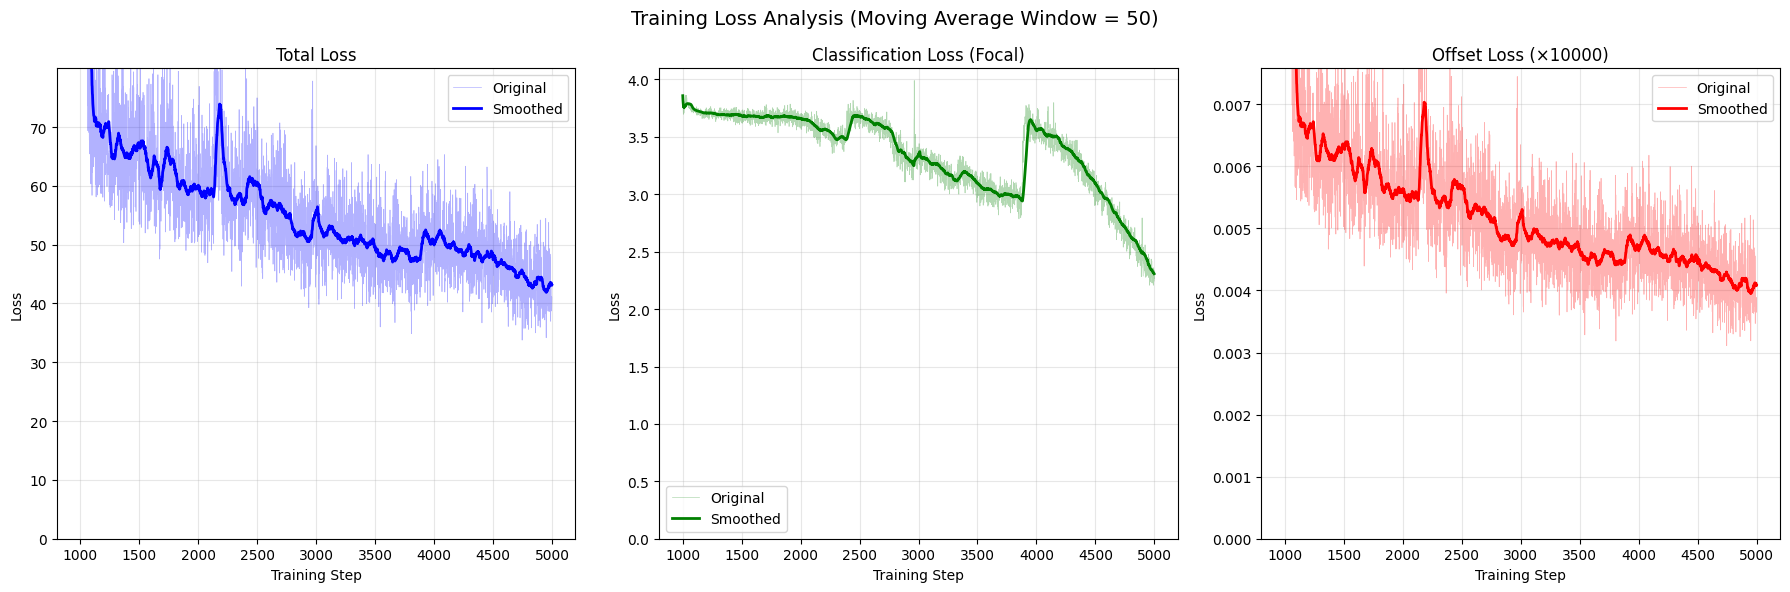

In [19]:
# run after training has completed
from plot_utils import plot_training_losses, visualize_action_clusters
# Adjust smoothing and figure size:
plot_training_losses(classification_losses, offset_losses, policy, 
                    window_size=50, figsize=(18, 6), skip_initial=1000)

Clusters: 50 total, 0 unused (0.0%)
Action range: [17.0, 507.0]
Cluster range: [51.9, 471.2]


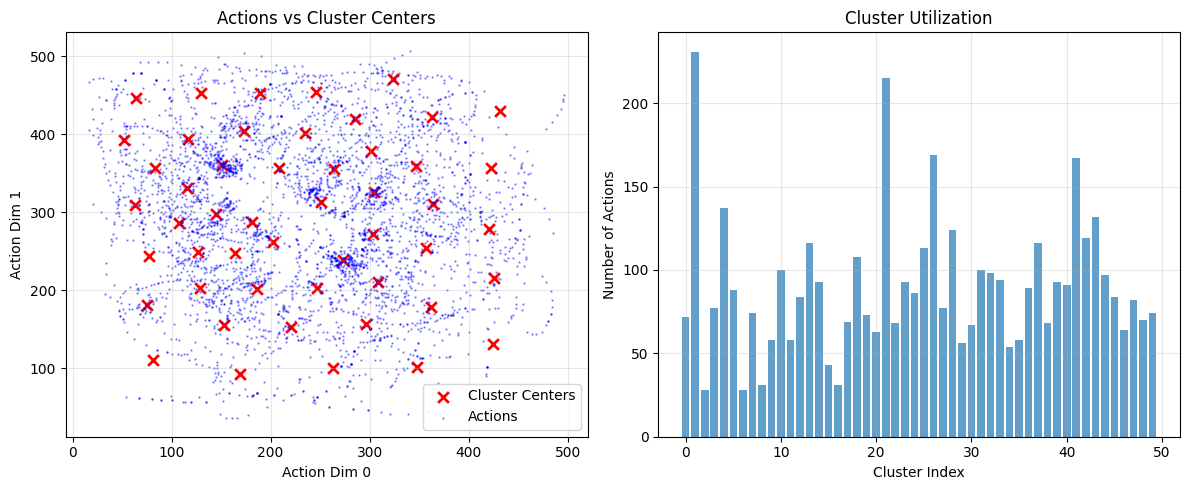

In [20]:
visualize_action_clusters(policy, dataloader, device, max_batches=10, figsize=(12, 5))

In [39]:
import gym_pusht  # noqa: F401
import gymnasium as gym
import imageio
import numpy

device = "cuda"

# pretrained_policy_path = Path("outputs/train/test_bet")
# trained_policy = DiffusionPolicy.from_pretrained(pretrained_policy_path)

# Initialize evaluation environment to render two observation types:
# an image of the scene and state/position of the agent
env = gym.make(
    "gym_pusht/PushT-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=300,
)

print(policy.config.input_features)
print(env.observation_space)
print(policy.config.output_features)
print(env.action_space)


{'observation.image': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 96, 96)), 'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>, shape=(2,))}
Dict('agent_pos': Box(0.0, 512.0, (2,), float64), 'pixels': Box(0, 255, (96, 96, 3), uint8))
{'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>, shape=(2,))}
Box(0.0, 512.0, (2,), float32)


In [ ]:
# Reset the policy and environments to prepare for rollout
policy.reset()
numpy_observation, info = env.reset(seed=42)

rewards = []
frames = []

frames.append(env.render())

step = 0
done = False
while not done:
    # Prepare observation for the policy running in Pytorch
    state = torch.from_numpy(numpy_observation["agent_pos"])
    image = torch.from_numpy(numpy_observation["pixels"])

    # Convert to float32 with image from channel first in [0,255]
    # to channel last in [0,1]
    state = state.to(torch.float32)
    image = image.to(torch.float32) / 255
    image = image.permute(2, 0, 1)

    # Send data tensors from CPU to GPU
    state = state.to(device, non_blocking=True)
    image = image.to(device, non_blocking=True)

    # Add extra (empty) batch dimension, required to forward the policy
    state = state.unsqueeze(0)
    image = image.unsqueeze(0)

    # Create the policy input dictionary
    observation = {
        "observation.state": state,
        "observation.image": image,
    }

    # Predict the next action with respect to the current observation
    with torch.inference_mode():
        action = policy.select_action(observation)

    # Prepare the action for the environment
    numpy_action = action.squeeze(0).to("cpu").numpy()
    print(f"numpy_action {numpy_action}")
    # Step through the environment and receive a new observation
    numpy_observation, reward, terminated, truncated, info = env.step(numpy_action)
    print(f"{step=} {reward=} {terminated=}")

    # Keep track of all the rewards and frames
    rewards.append(reward)
    frames.append(env.render())

    # The rollout is considered done when the success state is reached (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

# Get the speed of environment (i.e. its number of frames per second).
fps = env.metadata["render_fps"]

# Encode all frames into a mp4 video.
video_path = output_directory / "rollout.mp4"
imageio.mimsave(str(video_path), numpy.stack(frames), fps=fps)

print(f"Video of the evaluation is available in '{video_path}'.")

### Final Model Evaluation

Resolving data files:   0%|          | 0/206 [00:00<?, ?it/s]

number of parameters: 26.00M
self._offset_loss_multiplier: 1000.0
Loading weights from local directory
Clusters: 50 total, 0 unused (0.0%)
Action range: [21.0, 510.0]
Cluster range: [51.3, 466.5]


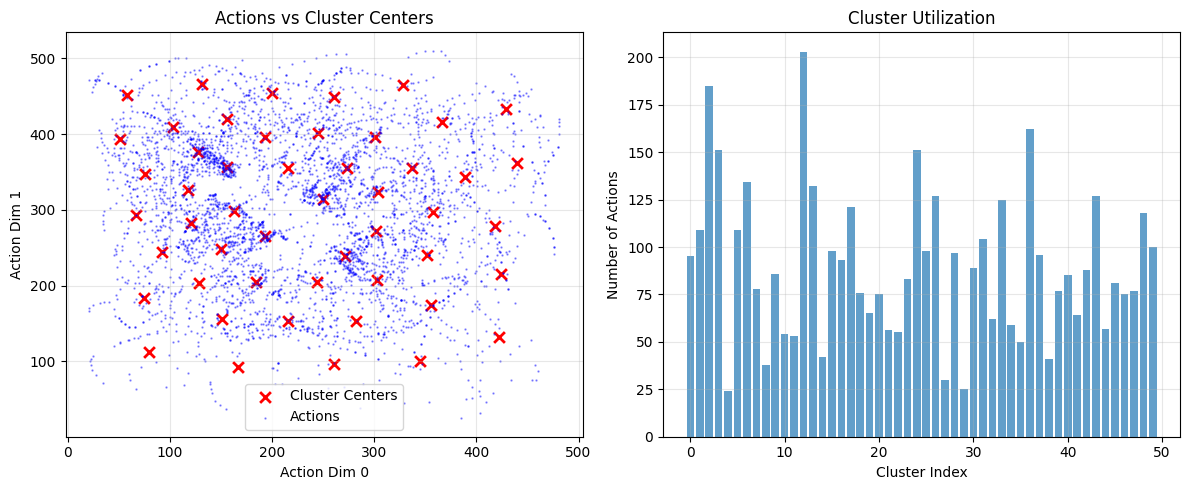

In [11]:
# Plot Clustering of final model
# Comment out below when only running this cell

# from lerobot.policies.bet.modeling_bet import BeTPolicy
# from lerobot.policies.bet.configuration_bet import BeTConfig
# from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
# from lerobot.datasets.utils import dataset_to_policy_features
# from lerobot.configs.types import FeatureType

# dataset_metadata = LeRobotDatasetMetadata("lerobot/pusht")
# features = dataset_to_policy_features(dataset_metadata.features)
# output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
# input_features = {key: ft for key, ft in features.items() if key not in output_features}

# device = torch.device("cuda")
# cfg = BeTConfig(input_features=input_features, output_features=output_features)

# delta_timestamps = {
#     "observation.image": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
#     "observation.state": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
#     "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
# }
# dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)

# dataloader = torch.utils.data.DataLoader(
#     dataset,
#     num_workers=4,
#     batch_size=64,
#     shuffle=True,
#     pin_memory=device.type != "cpu",
#     drop_last=True,
# )

from plot_utils import visualize_action_clusters

bet_pretrained_policy_path = Path("outputs/train/test_bet_30k_off1000")

bet_policy = BeTPolicy.from_pretrained(bet_pretrained_policy_path)

visualize_action_clusters(bet_policy, dataloader, device, max_batches=10, figsize=(12, 5))

Loading weights from local directory
number of parameters: 26.00M
Loading weights from local directory
number of parameters: 26.00M
self._offset_loss_multiplier: 1000.0
Loading weights from local directory
Success for: BeT
Success for: Diffusion Policy
Success for: Diffusion Policy
Success for: Diffusion Policy


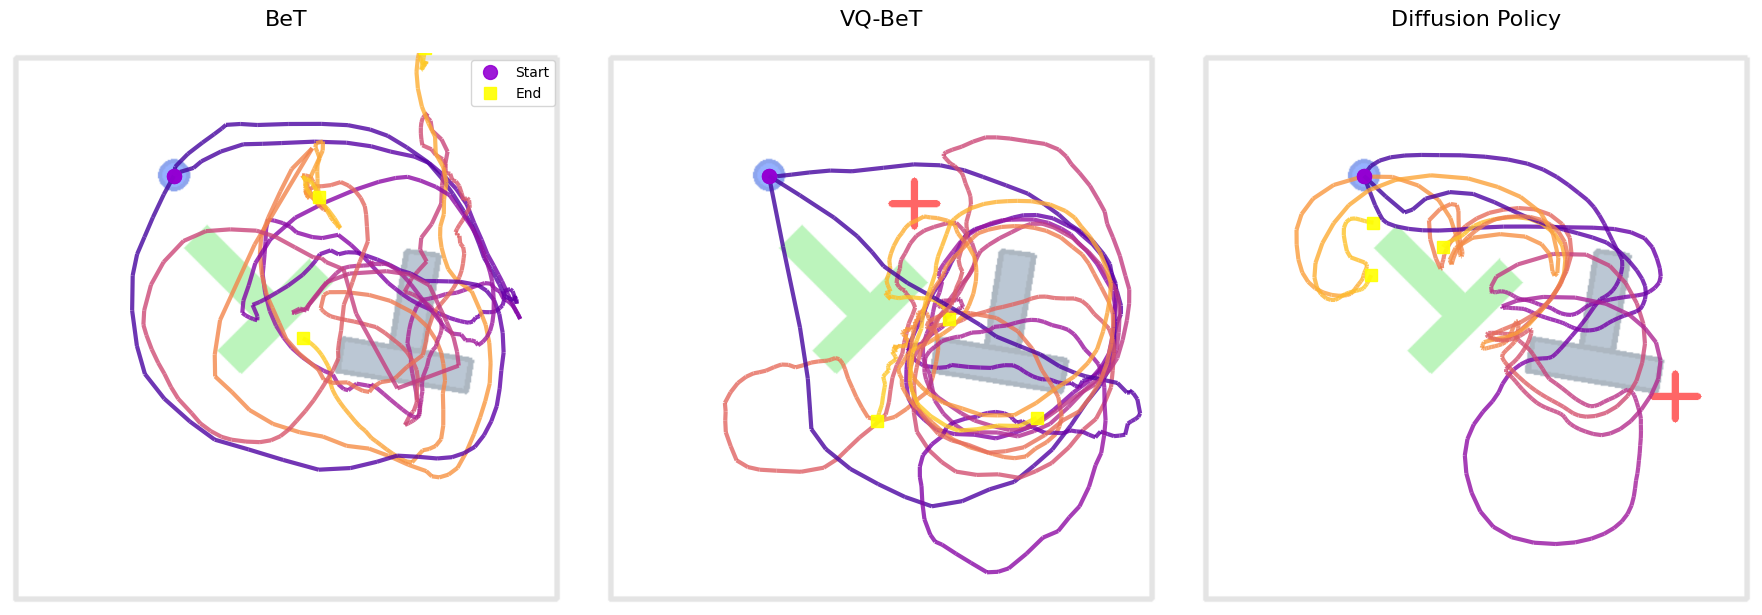

In [3]:
import gym_pusht  # noqa: F401
import gymnasium as gym
import torch
from pathlib import Path

from plot_utils import create_trajectory_comparison_plot

device = torch.device("cuda")

env = gym.make(
    "gym_pusht/PushT-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=300,
)
from lerobot.policies.diffusion.modeling_diffusion import DiffusionPolicy
from lerobot.policies.vqbet.modeling_vqbet import VQBeTPolicy
from lerobot.policies.bet.modeling_bet import BeTPolicy
diffusion_pretrained_policy_path = Path("outputs/train/diffusion_pusht_baseline/checkpoints/last/pretrained_model")
vqbet_pretrained_policy_path = Path("outputs/train/vqbet_pusht_baseline/checkpoints/last/pretrained_model")
# bet_pretrained_policy_path = Path("lerobot/_st25000/checkpoints/last/pretrained_model")
bet_pretrained_policy_path = Path("outputs/train/test_bet_30k_off1000")

diffusion_policy = DiffusionPolicy.from_pretrained(diffusion_pretrained_policy_path)
vqbet_policy = VQBeTPolicy.from_pretrained(vqbet_pretrained_policy_path)
bet_policy = BeTPolicy.from_pretrained(bet_pretrained_policy_path)

create_trajectory_comparison_plot({'BeT': bet_policy, "VQ-BeT": vqbet_policy, 'Diffusion Policy': diffusion_policy}, 
                                  env, num_rollouts=3, max_steps=300,
                                  device=device
                                 )